In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score
from collections import Counter
import sklearn
import csv
import pandas as pd
from datetime import datetime
import json
from tensorflow.keras.callbacks import Callback

# Baseline model

## Loading dataset

In [ ]:
images = np.load('/content/drive/MyDrive/MaskDetection/images.npy')
labels = np.load('/content/drive/MyDrive/MaskDetection/labels.npy')

In [ ]:
print(images.shape)

(9398, 80, 80, 3)


## Functions

In [ ]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

In [ ]:
def data_split(images, labels, test_size):
  if test_size < 1:
    test_size = int(len(images) * test_size)
  
  images, labels = shuffle(images, labels)
  X_test = images[:test_size]
  y_test = labels[:test_size]
  X_train = images[test_size:]
  y_train = labels[test_size:]

  return X_train, y_train, X_test, y_test

In [ ]:
def split_data(images, labels, ratio):
  assert sum(ratio) == 1
  images, labels = sklearn.utils.shuffle(images, labels, random_state=42)

  ret = []
  pos = 0
  for r in ratio:
    size = int(len(images) * r)
    s_images = images[pos:pos+size]
    s_labels = labels[pos:pos+size]
    pos += size
    ret.extend([s_images, s_labels])

  return tuple(ret)

In [ ]:
def preprocess(image):
  return image / 127.5 - 1.0

In [ ]:
def logger(filename, data):
  if os.path.isfile(filename):
    df = pd.read_csv(filename)
    new_df = pd.DataFrame.from_records([data])
    df = pd.concat([df, new_df], axis=0)
  else:
    df = pd.DataFrame().from_records([data])
  df.to_csv(filename, index=False)

In [ ]:
def save_history(filename, history):
  df = pd.DataFrame.from_dict(data=history)
  df.to_csv(filename)

In [ ]:
def save_model_json(filename, model):
  config = model.to_json()
  with open(filename, 'w') as f:
    json.dump(config, f)

In [ ]:
def create_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)

In [ ]:
def classification_report(model, X_test, y_test, target_names):
  y_pred = model.predict(X_test)
  report = sklearn.metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names, output_dict=True)
  text_report = sklearn.metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)
  print(text_report)
  return report

In [ ]:
def pipeline(model, train_data, valid_data, fit_params, generator, filename, directory, date, other=None):
  if directory[-1] != '/':
    directory += '/'
  
  results_path = directory+'Results_'+filename+'/'
  plots_path = results_path+'Plots_'+filename+'/'
  hist_path = results_path+'Histories_'+filename+'/'
  models_path = results_path+'Models_'+filename+'/'

  paths = [results_path, plots_path, hist_path, models_path]
  for path in paths:
    create_dir(path)

  d = dict()
  d.update({'date':date})
  d.update(fit_params)
  d.update(generator.__dict__)
  if isinstance(other, dict):
    d.update(other)
  H = model.fit(x=train_data,
                validation_data=valid_data,
                **fit_params)
  save_history(hist_path+date+'.csv', H.history)
  make_plot(plots_path+date+'.png', H)
  save_model_json(models_path+date+'.json', model)

  target_names = ['valid_'+c for c in lb.classes_]
  results = classification_report(model, X_valid_norm, y_valid, target_names=target_names)
  d.update(results)

  target_names = ['test_'+c for c in lb.classes_]
  results = classification_report(model, X_test_norm, y_test, target_names=target_names)
  d.update(results)

  filename = results_path+filename+'.csv'
  logger(filename, d)

  return H

In [ ]:
def make_plot(filename, H):
  from datetime import datetime
  plt.figure()
  keys = list(H.history.keys())
  for key in keys: 
    plt.plot(H.history[key])
    plt.ylabel('value')
    plt.xlabel('epoch')
  plt.legend(keys)
  plt.savefig(filename)
  plt.show()

In [ ]:
def accuracy(model, X_test, y_test, class_name=None):
  if class_name:
    labels = lb.inverse_transform(y_test)
    indices = np.where(labels == class_name)[0]
    X_test = X_test[indices]
    y_test = y_test[indices]
  test_preds = model.predict(X_test)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(y_test, test_preds)
  return round(m.result().numpy(),4)

In [ ]:
class MetricsCallback(Callback):
    def __init__(self, test_data, y_true, directory, filename, date):
        # Should be the label encoding of your classes
        self.y_true = y_true
        self.test_data = test_data
        self.date = date
        self.best_result = 0
        if directory[-1] != '/':
          directory += '/'
        self.results_path = directory+'Results_'+filename+'/'
        self.callbacks_path = self.results_path+'Callbacks_'+filename+'/'
        self.models_path = self.results_path+'Models_'+filename+'/'
        paths = [self.results_path, self.callbacks_path, self.models_path]
        for path in paths:
          create_dir(path)
        
    def on_epoch_end(self, epoch, logs=None):
        # Here we get the probabilities
        y_pred = self.model.predict(self.test_data)
        # Here we get the actual classes
        y_pred = tf.argmax(y_pred,axis=1)
        # Actual dictionary
        report_dictionary = classification_report(self.model, self.test_data, self.y_true, lb.classes_)

        mean_f1_score = 0
        for c in lb.classes_:
          mean_f1_score += report_dictionary[c]['f1-score']
        mean_f1_score /= len(lb.classes_)
        if mean_f1_score > self.best_result:
          self.best_result = mean_f1_score
          self.model.save_weights(self.models_path+self.date+'.h5')
          print('Model saved\n')
        logger(self.callbacks_path+self.date+'.csv', report_dictionary)

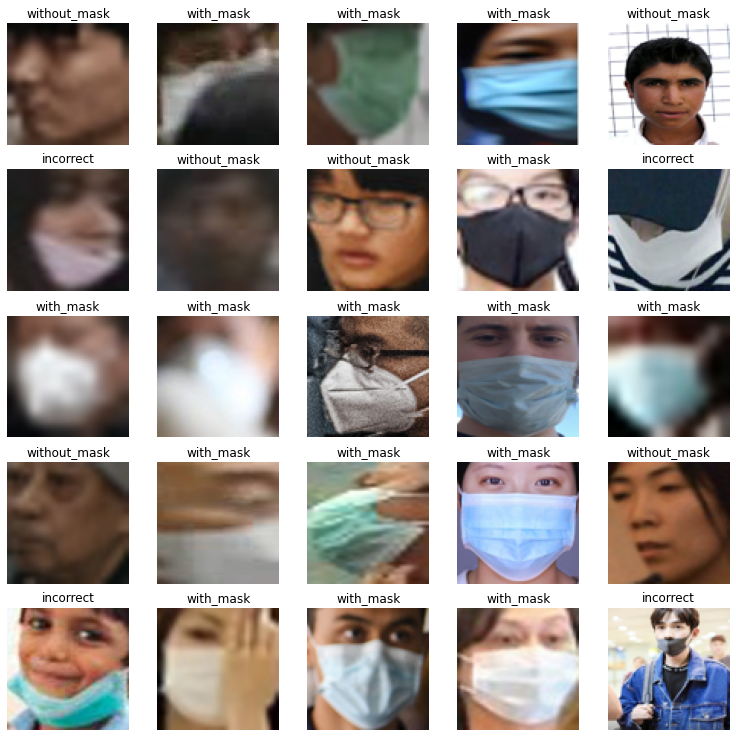

In [ ]:
make_preview(images, labels)

## Splitting the data set into training and test data sets

In [ ]:
# Divide dataset into classes
with_mask = np.where(labels == 'with_mask')
with_mask_data = images[with_mask]
with_mask_labels = labels[with_mask]

without_mask = np.where(labels == 'without_mask')
without_mask_data = images[without_mask]
without_mask_labels = labels[without_mask]

incorrect_mask = np.where(labels == 'incorrect')
incorrect_data = images[incorrect_mask]
incorrect_labels = labels[incorrect_mask]

In [ ]:
print(len(with_mask_data), len(without_mask_data), len(incorrect_data))

6894 1984 520


In [ ]:
#Split data into train, valid and test set

#with mask
with_X_train, with_y_train, with_X_valid, with_y_valid, with_X_test, with_y_test = split_data(with_mask_data, with_mask_labels, [0.6, 0.2, 0.2])
print(len(with_X_train), len(with_X_valid), len(with_X_test))

#without mask
without_X_train, without_y_train, without_X_valid, without_y_valid, without_X_test, without_y_test = split_data(without_mask_data, without_mask_labels, [0.6, 0.2, 0.2])
print(len(without_X_train), len(without_X_valid), len(without_X_test))

#incorrect worn mask
incorrect_X_train, incorrect_y_train, incorrect_X_valid, incorrect_y_valid, incorrect_X_test, incorrect_y_test = split_data(incorrect_data, incorrect_labels, [0.6, 0.2, 0.2])
print(len(incorrect_X_train), len(incorrect_X_valid), len(incorrect_X_test))

4136 1378 1378
1190 396 396
312 104 104


In [ ]:
X_train = np.concatenate([with_X_train, without_X_train, incorrect_X_train], axis=0)
y_train = np.concatenate([with_y_train, without_y_train, incorrect_y_train], axis=0)

X_valid = np.concatenate([with_X_valid, without_X_valid, incorrect_X_valid], axis=0)
y_valid = np.concatenate([with_y_valid, without_y_valid, incorrect_y_valid], axis=0)

X_test = np.concatenate([with_X_test, without_X_test, incorrect_X_test], axis=0)
y_test = np.concatenate([with_y_test, without_y_test, incorrect_y_test], axis=0)

vectorized_preprocess = np.vectorize(preprocess)
X_test_norm = vectorized_preprocess(X_test)
X_valid_norm = vectorized_preprocess(X_valid)

print(len(X_train), len(X_valid), len(X_test))

5638 1878 1878


In [ ]:
del with_X_train
del with_y_train
del with_X_test
del with_y_test

del without_X_train
del without_y_train
del without_X_test
del without_y_test

del incorrect_X_train
del incorrect_y_train
del incorrect_X_test
del incorrect_y_test

## Encoding labels

In [ ]:
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.transform(y_valid)
y_test = lb.transform(y_test)

In [ ]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

## Data Generator

In [ ]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.15,
	  height_shift_range=0.15,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest")

In [ ]:
init_lr = 1e-4
epochs = 20
batch_size = 64
input_shape = (80,80,3)
directory = '/content/drive/MyDrive/MaskDetection'
filename = '04_04_2021'

In [ ]:
train_gen = gen.flow(
x=X_train,
y=y_train,
batch_size=batch_size,
seed=42,
shuffle=True)

## Simple model

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
input = tf.keras.layers.Input(shape=input_shape)
out = tf.keras.layers.Conv2D(100, (3,3), activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(input)
out = tf.keras.layers.Conv2D(100, (3,3), strides=2, activation='relu')(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dropout(0.5)(out)
out = tf.keras.layers.Dense(50, activation='relu')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)
model = tf.keras.models.Model(input, out)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/init_weights_04_04_2021_baseline.h5')

In [ ]:
#reset model - load init weights
model.load_weights('/content/drive/MyDrive/MaskDetection/init_weights_04_04_2021_baseline.h5')

In [ ]:
#reset generators
train_gen.reset()
valid_gen.reset()

Epoch 1/20
89/89 [==============================] - 19s 136ms/step - loss: 0.5119 - acc: 0.8168 - val_loss: 0.2951 - val_acc: 0.9026


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   incorrect       0.00      0.00      0.00       104
   with_mask       0.91      0.98      0.95      1378
without_mask       0.87      0.86      0.87       396

    accuracy                           0.90      1878
   macro avg       0.59      0.62      0.60      1878
weighted avg       0.85      0.90      0.88      1878

Model saved

Epoch 2/20
89/89 [==============================] - 11s 126ms/step - loss: 0.3298 - acc: 0.8983 - val_loss: 0.2391 - val_acc: 0.9185
              precision    recall  f1-score   support

   incorrect       0.33      0.01      0.02       104
   with_mask       0.93      0.98      0.96      1378
without_mask       0.87      0.94      0.91       396

    accuracy                           0.92      1878
   macro avg       0.71      0.64      0.63      1878
weighted avg       0.89      0.92      0.89      1878

Model saved

Epoch 3/20
89/89 [==============================] - 11s 128ms/step - loss: 0.29

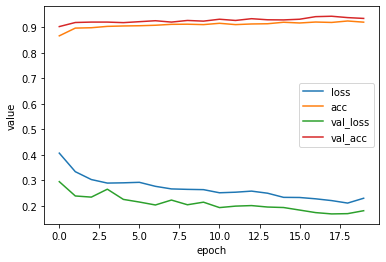

                    precision    recall  f1-score   support

   valid_incorrect       0.78      0.24      0.37       104
   valid_with_mask       0.95      0.98      0.97      1378
valid_without_mask       0.90      0.94      0.92       396

          accuracy                           0.93      1878
         macro avg       0.88      0.72      0.75      1878
      weighted avg       0.93      0.93      0.92      1878

                   precision    recall  f1-score   support

   test_incorrect       0.77      0.29      0.42       104
   test_with_mask       0.95      0.98      0.96      1378
test_without_mask       0.91      0.93      0.92       396

         accuracy                           0.93      1878
        macro avg       0.87      0.73      0.77      1878
     weighted avg       0.93      0.93      0.92      1878



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             description='Simple baseline model')
H = pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

**Due to the very unbalanced dataset there is a very low accuracy when classifying images with an incorrectly worn mask.**

## Weight balancing

In [ ]:
#reset model - load init weights
model.load_weights('/content/drive/MyDrive/MaskDetection/init_weights_04_04_2021_baseline.h5')

In [ ]:
train_gen.reset()

In [ ]:
class_weight = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                               np.unique(np.argmax(y_train, axis=1)),
                                                               np.argmax(y_train, axis=1))
class_weight = {i:class_weight[i] for i in range(len(class_weight))}
class_weight

{0: 6.023504273504273, 1: 0.4543842682140555, 2: 1.5792717086834733}

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
batch_size=32

train_gen = gen.flow(
x=X_train,
y=y_train,
batch_size=batch_size,
seed=42,
shuffle=True)

Epoch 1/20
89/89 [==============================] - 12s 130ms/step - loss: 0.8850 - acc: 0.6467 - val_loss: 0.5482 - val_acc: 0.8253
              precision    recall  f1-score   support

   incorrect       0.21      0.54      0.30       104
   with_mask       0.98      0.81      0.89      1378
without_mask       0.81      0.95      0.87       396

    accuracy                           0.83      1878
   macro avg       0.66      0.77      0.69      1878
weighted avg       0.90      0.83      0.85      1878

Model saved

Epoch 2/20
89/89 [==============================] - 12s 130ms/step - loss: 0.6956 - acc: 0.7662 - val_loss: 0.4073 - val_acc: 0.8701
              precision    recall  f1-score   support

   incorrect       0.32      0.52      0.39       104
   with_mask       0.98      0.87      0.92      1378
without_mask       0.79      0.95      0.87       396

    accuracy                           0.87      1878
   macro avg       0.70      0.78      0.73      1878
weighted avg  

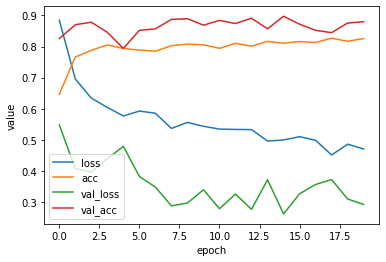

                    precision    recall  f1-score   support

   valid_incorrect       0.33      0.80      0.46       104
   valid_with_mask       0.99      0.87      0.93      1378
valid_without_mask       0.90      0.93      0.91       396

          accuracy                           0.88      1878
         macro avg       0.74      0.87      0.77      1878
      weighted avg       0.93      0.88      0.90      1878

                   precision    recall  f1-score   support

   test_incorrect       0.30      0.78      0.43       104
   test_with_mask       0.99      0.84      0.91      1378
test_without_mask       0.84      0.93      0.88       396

         accuracy                           0.86      1878
        macro avg       0.71      0.85      0.74      1878
     weighted avg       0.92      0.86      0.88      1878



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  class_weight=class_weight,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             description='Simple baseline model with weight balancing')
pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

## Oversampling

### CombinedGen

In [ ]:
class CombinedGen():
    def __init__(self, x, y, batch_size, ratio):
        self.batch_size=batch_size
        self.x=x
        self.y=y
        self.ratio=ratio
        sizes = [int(round(r*batch_size, 0)) for r in ratio]
        assert sum(sizes) == batch_size 
        self.train_gens = self.combine_generators(x, y, sizes)
        self.train_gen = self.init_generators(self.train_gens)

    def combine_generators(self, x, y, sizes):
      train_gens = []

      for c, s in zip(lb.classes_, sizes):
        indices = np.where(lb.inverse_transform(y) == c)[0]
        xc = x[indices]
        yc = y[indices]

        t_gen = gen.flow(
        x=xc,
        y=yc,
        batch_size=s,
        seed=42,
        shuffle=True)

        train_gens.append(t_gen)

      return train_gens

    def init_generators(self, generators):
      while True:
        images = []
        labels = []
        for g in generators:
          img, lab = g.next()
          images.append(img)
          labels.append(lab)
        
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)
        images, labels = sklearn.utils.shuffle(images, labels)
        yield (images, labels)
    
    def reset_generators(self):
      for g in self.train_gens:
        g.reset()
      self.train_gen = self.init_generators(self.train_gens)

    def generate_train(self):
      return self.train_gen

    def train_len(self):
      return len(self.x)//batch_size

In [ ]:
def normalize(data):
  return np.clip((data + 1.0) * 127.5, 0, 255).astype(np.uint8)

### Model

In [ ]:
#reset model - load init weights
model.load_weights('/content/drive/MyDrive/MaskDetection/init_weights_04_04_2021_baseline.h5')

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
cg = CombinedGen(X_train, y_train, 64, [0.34, 0.33, 0.33])

Epoch 1/20
88/88 [==============================] - 12s 132ms/step - loss: 0.7860 - acc: 0.6735 - val_loss: 0.4324 - val_acc: 0.8866
              precision    recall  f1-score   support

   incorrect       0.32      0.61      0.42       104
   with_mask       0.98      0.90      0.94      1378
without_mask       0.88      0.90      0.89       396

    accuracy                           0.89      1878
   macro avg       0.73      0.80      0.75      1878
weighted avg       0.92      0.89      0.90      1878

Model saved

Epoch 2/20
88/88 [==============================] - 11s 131ms/step - loss: 0.5964 - acc: 0.7574 - val_loss: 0.4064 - val_acc: 0.8440
              precision    recall  f1-score   support

   incorrect       0.24      0.73      0.36       104
   with_mask       0.98      0.85      0.91      1378
without_mask       0.91      0.85      0.88       396

    accuracy                           0.84      1878
   macro avg       0.71      0.81      0.72      1878
weighted avg  

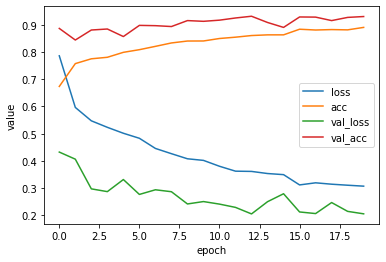

                    precision    recall  f1-score   support

   valid_incorrect       0.52      0.80      0.63       104
   valid_with_mask       0.99      0.94      0.96      1378
valid_without_mask       0.91      0.95      0.93       396

          accuracy                           0.93      1878
         macro avg       0.81      0.89      0.84      1878
      weighted avg       0.94      0.93      0.94      1878

                   precision    recall  f1-score   support

   test_incorrect       0.46      0.79      0.58       104
   test_with_mask       0.99      0.91      0.95      1378
test_without_mask       0.85      0.93      0.89       396

         accuracy                           0.91      1878
        macro avg       0.77      0.88      0.81      1878
     weighted avg       0.93      0.91      0.92      1878



In [ ]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             description='Simple baseline model with oversampling, correct number of steps')
pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)